## BMENE4460 Final Project
### Eugénie Dulout & Antoine Andurao

**VGG and Transformers with 1 slice**

This notebook contains our experiments with Transfer Learning on VGG11, SwinT and ViT.

In this file, the input to each model was a [3, 224, 224] Tensor, each channel being a the same coronal slice from the same MRI (the same image is stacked 3 times because all models were pretrained on color images).

In [ ]:
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset
from glob import glob
import torch
from tqdm import tqdm
from skimage.measure import label, regionprops
from skimage import exposure
from scipy.ndimage.morphology import binary_fill_holes

# set random seed
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Train Dataset
class MRIDataset(Dataset):
    def __init__(self, paths, mode, slices_index, transform=None):
        print('***************')
        print('MRIDataset')
        self.images = []
        self.labels = []
        self.paths = paths
        print(f'Load T1. Total T1 {mode} number is: ' + str(len(self.paths)))

        self.transform = transform

        AD_count = 0
        CN_count = 0

        for path in tqdm(self.paths, total=len(self.paths), desc="Loading Nifti images, and getting slices"):

          label = path.split('/')[-2]
          label = (1 if label == 'AD' else 0)

          current_T1 = None
          T1_dimension = (182, 218, 182)

          current_T1 = nib.load(path).get_fdata().astype(np.float32)

          current_T1 = current_T1 / current_T1.max()

          slice1 = current_T1[:,slices_index,:]

          if self.transform:
            slice1 = self.transform(slice1).squeeze()

          self.images.append(torch.stack([slice1, slice1, slice1]))
          self.labels.append(label)

        print(f'Total loaded slices: {str(len(self.images))}')

    def __len__(self):

        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class CLAHE():
    def __init__(self, clip_limit=0.02, tile_grid_size=(8, 8)):
        """
        Initialize CLAHE parameters.
        :param clip_limit: Threshold for contrast limiting.
        :param tile_grid_size: Size of the grid for the histogram equalization.
        """
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        """
        Apply CLAHE to a torch Tensor image.
        :param img: The input image torch Tensor.
        :return: Image after CLAHE as a torch Tensor.
        """
        # Ensure the image tensor is on CPU and convert it to numpy
        if isinstance(img, torch.Tensor):
            img = img.cpu()

        img_np = img.numpy()

        # Normalize the image data to [0, 1] for processing with skimage
        img_min = img_np.min()
        img_max = img_np.max()
        img_np = (img_np - img_min) / (img_max - img_min)

        # Apply CLAHE
        if img_np.ndim == 3:
            img_np = img_np[0]  # Remove channel dimension for processing

        clahe = exposure.equalize_adapthist(
            img_np,
            clip_limit=self.clip_limit,
            nbins=256,
            kernel_size=self.tile_grid_size
        )

        # Rescale back to the original range
        clahe = clahe * (img_max - img_min) + img_min

        # Convert back to a tensor
        clahe_tensor = torch.from_numpy(clahe).float()

        # Re-add the channel dimension if it was initially present
        if img.ndim == 3:
            clahe_tensor = clahe_tensor.unsqueeze(0)

        return clahe_tensor

<ipython-input-1-dc1ddea32cdd>:9: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


In [ ]:
import os
import time
import numpy as np

import torch
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.nn.utils import clip_grad_value_
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_curve, auc
import scipy

In [ ]:
# Transform pipeline using torchvision
transforms_pipeline_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    CLAHE(),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5))
])

In [ ]:
def filter_paths(n_patients, paths):
    AD_count, CN_count = 0, 0
    filtered_paths = []
    for idx in range(len(paths)):

              label = paths[idx].split('/')[-2]
              label = (1 if label == 'AD' else 0)

              if AD_count>=n_patients and CN_count>=n_patients:
                break
              elif label == 1:
                if AD_count>=n_patients:
                  continue
                else:
                  filtered_paths.append(paths[idx])
                  AD_count += 1
              else:
                if CN_count>=n_patients:
                  continue
                else:
                  filtered_paths.append(paths[idx])
                  CN_count += 1
    return filtered_paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_path = "/content/drive/My Drive/BMENE4460/Final Project/"

# define dataset dir
TrainDataDir = main_path + 'ADNI_large_sample/train/'
ValidationDataDir = main_path + 'ADNI_large_sample/validation/'

train_paths = filter_paths(1000, sorted(glob(TrainDataDir + 'T1_affine/*/*.nii.gz')))
val_paths = filter_paths(200, sorted(glob(ValidationDataDir + 'T1_affine/*/*.nii.gz')))

# Parameters to change
batch_size = 3
start_slice = 99
stop_slice = 101


# Train
Train_MRIDataset = MRIDataset(train_paths, slices_index=100, mode = 'train', transform=transforms_pipeline_train)
Train_dataloader = DataLoader(Train_MRIDataset, batch_size = batch_size,
                        shuffle=True, num_workers=0)


# Validation
Validation_MRIDataset = MRIDataset(val_paths, slices_index=100, mode = 'validation', transform=transforms_pipeline_train)

Val_dataloader = DataLoader(Validation_MRIDataset, batch_size = batch_size,
                        shuffle=True, num_workers=0)


***************
MRIDataset
Load T1. Total T1 train number is: 2000


Loading Nifti images, and getting slices: 100%|██████████| 2000/2000 [12:26<00:00,  2.68it/s]


Total loaded slices: 2000
***************
MRIDataset
Load T1. Total T1 validation number is: 253


Loading Nifti images, and getting slices: 100%|██████████| 253/253 [02:24<00:00,  1.75it/s]

Total loaded slices: 253


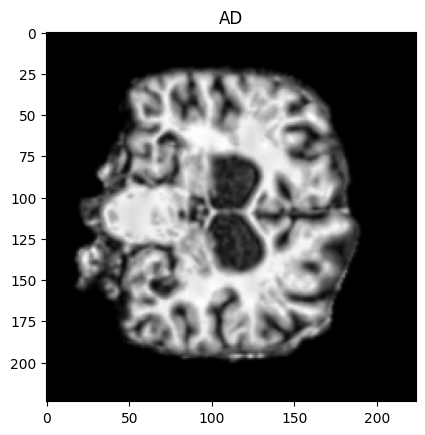

In [ ]:
import matplotlib.pyplot as plt

i = np.random.randint(len(Train_MRIDataset))
sample_T1 = Train_MRIDataset[i][0].cpu().numpy()
plt.imshow(sample_T1[0,:,:], cmap='gray')
plt.title("AD" if Train_MRIDataset[i][1]==1 else 'CN')
plt.show()

In [ ]:
save_dir = main_path + "/saved_models/"
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")  # Outputs the device being used

def compute_heatmap(model, image):
    model.eval()
    image = image.to(device)
    image.requires_grad = True
    with torch.set_grad_enabled(True):
        output = model(image.unsqueeze(0))
        predicted_class = torch.argmax(output, dim=1)
        model.vgg.classifier[6].weight.grad = None
        output[:, predicted_class].backward()

        heatmap = image.grad.squeeze().abs().detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
    return heatmap

def plot_heatmap(image, heatmap, title):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(heatmap, alpha=0.6, cmap='jet')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

def train(model, train_loader, val_loader, optimizer, criterion, device, save_dir, model_name="", epochs=10, patience=5):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Ensure the save directory exists

    train_losses = []
    val_losses = []
    accuracies = []

    best_val_acc = 0
    best_epoch = 0
    epochs_no_improve = 0

    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item() * images.size(0)

                predicted_labels = torch.argmax(output, dim=1)
                predictions.extend(predicted_labels.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        accuracy = accuracy_score(true_labels, predictions)
        accuracies.append(accuracy)

        scheduler.step(val_loss)

        print(f"Epoch {epoch}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

        if accuracy > best_val_acc:
            best_val_acc = accuracy

            if os.path.exists(os.path.join(save_dir, f'{model_name}_epoch_{best_epoch}.pt')):
              os.remove(os.path.join(save_dir, f'{model_name}_epoch_{best_epoch}.pt'))
            # Save the model
            model_path = os.path.join(save_dir, f'{model_name}_epoch_{epoch}.pt')
            torch.save(model.state_dict(), model_path)

            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break

    # Plot loss and validation curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return best_epoch

Running on: cuda


In [ ]:
# define dataset dir
TestDataDir = main_path + 'ADNI_large_sample/test/'

test_paths = filter_paths(100, sorted(glob(TestDataDir + 'T1_affine/*/*.nii.gz')))

# Parameters to change
batch_size = 3
start_slice = 99
stop_slice = 101

# Train
Test_MRIDataset = MRIDataset(test_paths, slices_index=100, mode = 'test', transform=transforms_pipeline_train)
Test_dataloader = DataLoader(Test_MRIDataset, batch_size = batch_size,
                        shuffle=True, num_workers=0)

***************
MRIDataset
Load T1. Total T1 test number is: 200


Loading Nifti images, and getting slices: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]

Total loaded slices: 200


In [ ]:
def load_by_epoch(model, model_name, save_dir, best_epoch, device):
  # Construct the model file name based on the best_epoch
    model_filename = f'{model_name}_epoch_{best_epoch}.pt'
    model_path = os.path.join(save_dir, model_filename)

    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No model found for best_epoch {best_epoch} at {model_path}")

    # Load the model
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    return model

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns  # Ensure seaborn is installed for better visualization

def cm_and_acc(model, test_loader, device):

    # Evaluate the model
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    labels = sorted(list(set(true_labels)))  # Get sorted list of classes

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["CN", "AD"], yticklabels=["CN", "AD"])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Display accuracy
    plt.figtext(0.5, 0.01, f'Accuracy: {accuracy * 100:.2f}%', ha='center', fontsize=12)
    plt.show()

    return accuracy

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix

def calculate_specificity(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    y_pred = []
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            # Assuming outputs are logits; apply sigmoid if needed
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(np.int32)  # Threshold the probabilities to obtain binary predictions

            y_scores.extend(probs[:, 1])  # Store probabilities for AUC calculation
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return y_true, y_pred, y_scores

## VGG11 - From scratch


In [ ]:
import torchvision.models as models

# Load pretrained VGG11 model
vgg11 = models.vgg11(weights=None)

# Modify the classifier
num_features = vgg11.classifier[6].in_features  # Get the number of input features to the last layer
vgg11.classifier[6] = nn.Linear(num_features, 2)  # Replace the last layer

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg11 = vgg11.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(vgg11.parameters(), lr=1e-5)  # Optimize only the classifier
criterion = nn.CrossEntropyLoss()

Epoch 1/25:
Train Loss: 0.6944, Val Loss: 0.6932, Accuracy: 0.5020
Epoch 2/25:
Train Loss: 0.6917, Val Loss: 0.6843, Accuracy: 0.4980
Epoch 3/25:
Train Loss: 0.6678, Val Loss: 0.5670, Accuracy: 0.6996
Epoch 4/25:
Train Loss: 0.5071, Val Loss: 0.4634, Accuracy: 0.7549
Epoch 5/25:
Train Loss: 0.2345, Val Loss: 0.5858, Accuracy: 0.7668
Epoch 6/25:
Train Loss: 0.0720, Val Loss: 0.6219, Accuracy: 0.7470
Epoch 7/25:
Train Loss: 0.0186, Val Loss: 1.3311, Accuracy: 0.6245
Epoch 8/25:
Train Loss: 0.0096, Val Loss: 0.6632, Accuracy: 0.7866
Epoch 9/25:
Train Loss: 0.0064, Val Loss: 0.7182, Accuracy: 0.7945
Epoch 10/25:
Train Loss: 0.0031, Val Loss: 0.7529, Accuracy: 0.7866
Epoch 11/25:
Train Loss: 0.0024, Val Loss: 0.7702, Accuracy: 0.7866
Epoch 12/25:
Train Loss: 0.0018, Val Loss: 0.7942, Accuracy: 0.7866
Epoch 13/25:
Train Loss: 0.0012, Val Loss: 0.7845, Accuracy: 0.7866
Epoch 14/25:
Train Loss: 0.0012, Val Loss: 0.7892, Accuracy: 0.7905
Epoch 15/25:
Train Loss: 0.0011, Val Loss: 0.7954, Accura

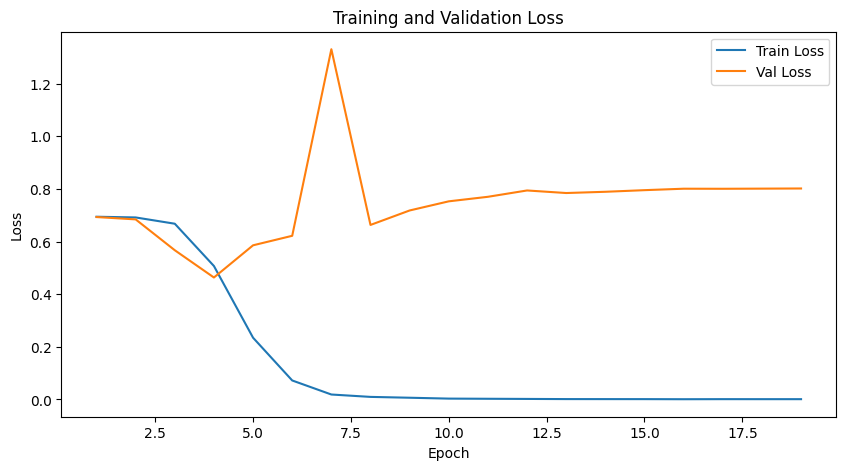

Training ended, best epoch is 9


In [ ]:
# Train the model
best_epoch = train(vgg11, Train_dataloader, Val_dataloader, optimizer, criterion, device, save_dir, model_name="vgg11_1x1_scratch", epochs=25, patience=10)
print(f"Training ended, best epoch is {best_epoch}")

In [ ]:
vgg11 = load_by_epoch(vgg11, "vgg11_1x1_scratch", save_dir, best_epoch, device)

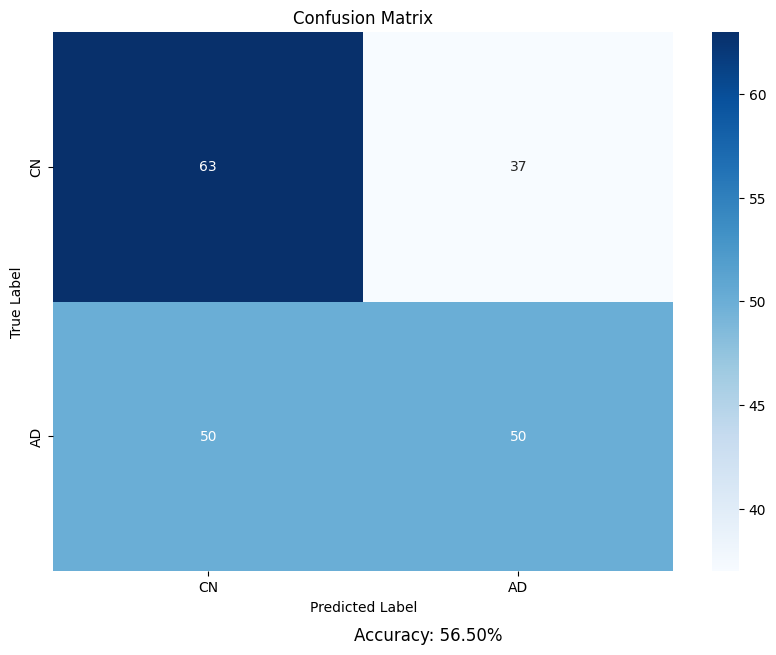

In [ ]:
accuracy = cm_and_acc(vgg11, Test_dataloader, device)

In [ ]:
y_true, y_pred, y_scores = evaluate_model(vgg11, Test_dataloader)

In [ ]:
auc = roc_auc_score(y_true, y_scores)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
specificity = calculate_specificity(y_true, y_pred)

print(f'AUC: {auc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')

AUC: 0.6435
Recall: 0.5
Precision: 0.5747126436781609
F1 Score: 0.5347593582887701
Specificity: 0.63


## VGG11


In [ ]:
import torchvision.models as models

# Load pretrained VGG11 model
vgg11 = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)

# Freeze the features part of the model
for param in vgg11.features.parameters():
    param.requires_grad = False

# Modify the classifier
num_features = vgg11.classifier[6].in_features  # Get the number of input features to the last layer
vgg11.classifier[6] = nn.Linear(num_features, 2)  # Replace the last layer

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg11 = vgg11.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(vgg11.classifier.parameters(), lr=1e-5)  # Optimize only the classifier
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:07<00:00, 71.2MB/s]


Epoch 1/25:
Train Loss: 0.6405, Val Loss: 0.5765, Accuracy: 0.7075
Epoch 2/25:
Train Loss: 0.4661, Val Loss: 0.5281, Accuracy: 0.6877
Epoch 3/25:
Train Loss: 0.2906, Val Loss: 0.5739, Accuracy: 0.6640
Epoch 4/25:
Train Loss: 0.1707, Val Loss: 0.6187, Accuracy: 0.6601
Epoch 5/25:
Train Loss: 0.0978, Val Loss: 0.6252, Accuracy: 0.6877
Epoch 6/25:
Train Loss: 0.0569, Val Loss: 0.8887, Accuracy: 0.6601
Epoch 7/25:
Train Loss: 0.0303, Val Loss: 0.8095, Accuracy: 0.6443
Epoch 8/25:
Train Loss: 0.0250, Val Loss: 0.8008, Accuracy: 0.6640
Epoch 9/25:
Train Loss: 0.0243, Val Loss: 0.8126, Accuracy: 0.6561
Epoch 10/25:
Train Loss: 0.0230, Val Loss: 0.8092, Accuracy: 0.6443
Epoch 11/25:
Train Loss: 0.0206, Val Loss: 0.8087, Accuracy: 0.6601
Early stopping triggered


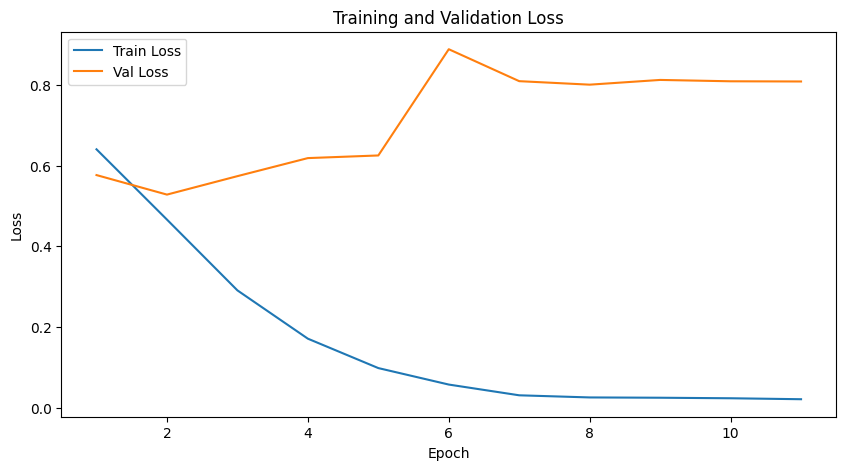

Training ended, best epoch is 1


In [ ]:
# Train the model
best_epoch = train(vgg11, Train_dataloader, Val_dataloader, optimizer, criterion, device, save_dir, model_name="vgg11_1x1_pretrained", epochs=25, patience=10)
print(f"Training ended, best epoch is {best_epoch}")

In [ ]:
vgg11 = load_by_epoch(vgg11, "vgg11_1x1_pretrained", save_dir, best_epoch, device)

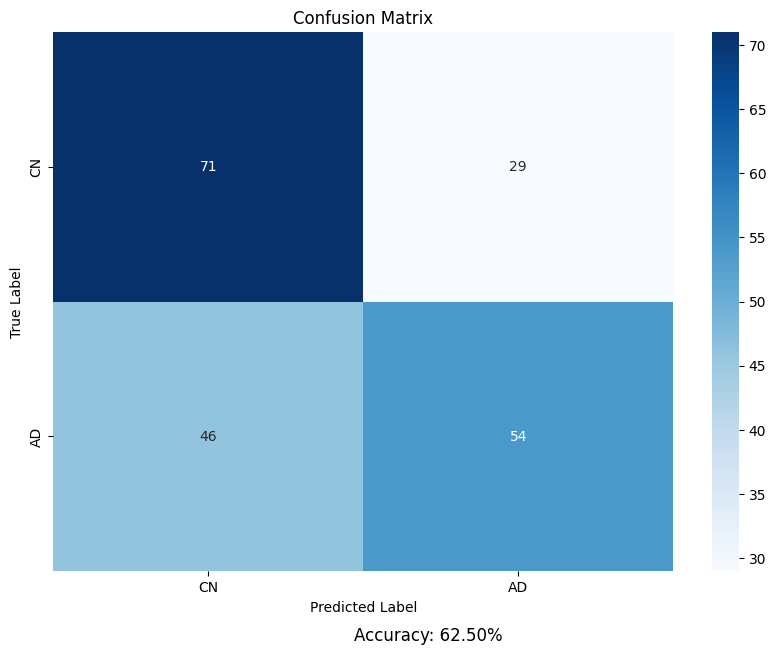

In [ ]:
accuracy = cm_and_acc(vgg11, Test_dataloader, device)

In [ ]:
y_true, y_pred, y_scores = evaluate_model(vgg11, Test_dataloader)

In [ ]:
auc = roc_auc_score(y_true, y_scores)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
specificity = calculate_specificity(y_true, y_pred)

print(f'AUC: {auc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')

AUC: 0.6569999999999999
Recall: 0.54
Precision: 0.6506024096385542
F1 Score: 0.5901639344262295
Specificity: 0.71


## SwinT

In [ ]:
from torchvision.models import swin_t, Swin_T_Weights
class SwinT(nn.Module):
  def __init__(self):
    super(SwinT, self).__init__()
    self.model1 = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

    self.fc1 = nn.Linear(1000, 2)

  def forward(self, x):
     x = self.model1(x)
     x = self.fc1(x)
     return x

In [ ]:
# Load pretrained Swin Transformer
swint = SwinT()

# Freeze all layers in the model
for param in swint.model1.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swint = swint.to(device)

# Optimize only the classifier
optimizer = optim.Adam(swint.fc1.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:02<00:00, 47.7MB/s]


Epoch 1/25:
Train Loss: 0.7015, Val Loss: 0.6592, Accuracy: 0.6443
Epoch 2/25:
Train Loss: 0.6914, Val Loss: 0.6446, Accuracy: 0.6996
Epoch 3/25:
Train Loss: 0.6885, Val Loss: 0.6331, Accuracy: 0.6957
Epoch 4/25:
Train Loss: 0.6789, Val Loss: 0.6293, Accuracy: 0.7312
Epoch 5/25:
Train Loss: 0.6754, Val Loss: 0.6188, Accuracy: 0.7628
Epoch 6/25:
Train Loss: 0.6734, Val Loss: 0.6158, Accuracy: 0.7905
Epoch 7/25:
Train Loss: 0.6667, Val Loss: 0.6064, Accuracy: 0.7787
Epoch 8/25:
Train Loss: 0.6674, Val Loss: 0.6008, Accuracy: 0.7945
Epoch 9/25:
Train Loss: 0.6640, Val Loss: 0.5926, Accuracy: 0.7905
Epoch 10/25:
Train Loss: 0.6689, Val Loss: 0.5887, Accuracy: 0.8024
Epoch 11/25:
Train Loss: 0.6634, Val Loss: 0.5836, Accuracy: 0.7905
Epoch 12/25:
Train Loss: 0.6640, Val Loss: 0.5799, Accuracy: 0.8063
Epoch 13/25:
Train Loss: 0.6588, Val Loss: 0.5762, Accuracy: 0.8142
Epoch 14/25:
Train Loss: 0.6557, Val Loss: 0.5756, Accuracy: 0.8142
Epoch 15/25:
Train Loss: 0.6600, Val Loss: 0.5727, Accura

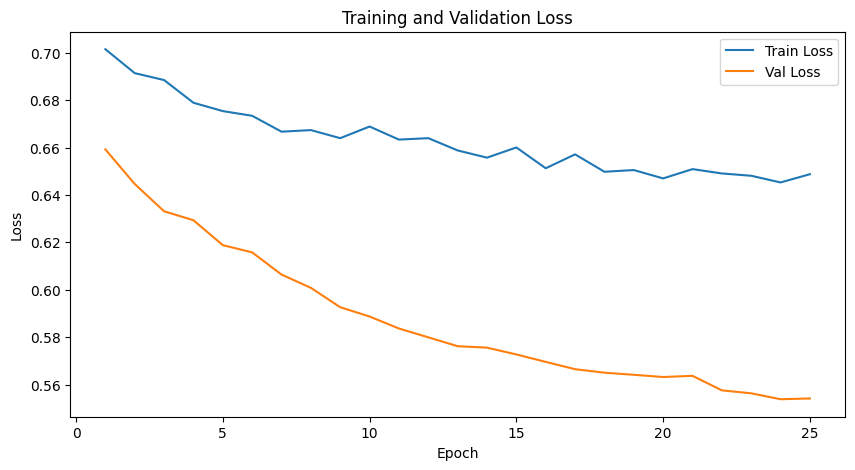

In [ ]:
# Train the model
best_epoch = train(swint, Train_dataloader, Val_dataloader, optimizer, criterion, device, save_dir, model_name="swint_1x1", epochs=25, patience=5)

In [ ]:
swint = load_by_epoch(swint, "swint_3x3", save_dir, 12, device)

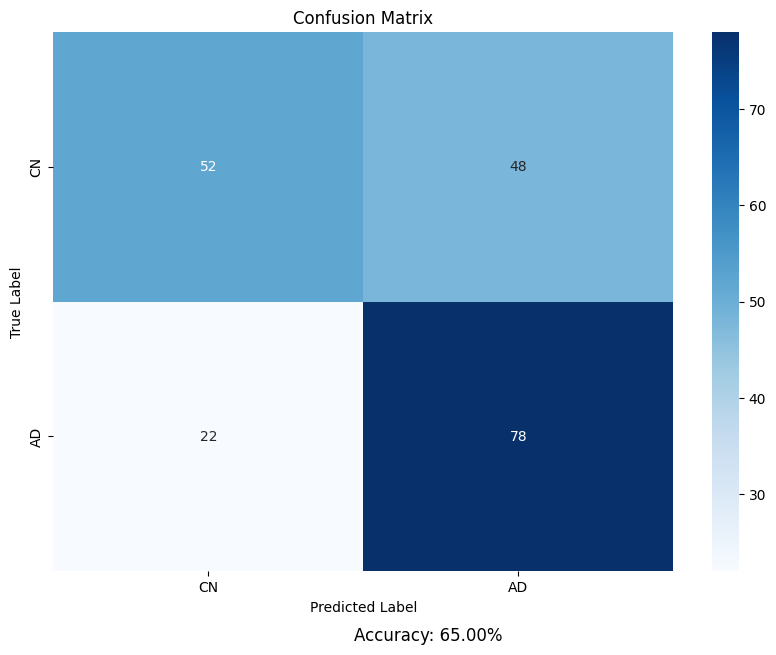

In [ ]:
accuracy = cm_and_acc(swint, Test_dataloader, device)

In [ ]:
y_true, y_pred, y_scores = evaluate_model(swint, Test_dataloader)

In [ ]:
auc = roc_auc_score(y_true, y_scores)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
specificity = calculate_specificity(y_true, y_pred)

print(f'AUC: {auc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')

AUC: 0.7284
Recall: 0.78
Precision: 0.6190476190476191
F1 Score: 0.6902654867256637
Specificity: 0.52


## ViT

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import timm

class ViT(nn.Module):
    def __init__(self, num_classes=2):
        super(ViT, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x

In [ ]:
ViT = ViT().to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# Freeze the features part of the model
for param in ViT.backbone.parameters():
    param.requires_grad = False
for param in ViT.backbone.head.parameters():
    param.requires_grad = True

# Optimize only the classifier
optimizer = optim.Adam(ViT.backbone.head.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

Epoch 1/25:
Train Loss: 0.7258, Val Loss: 0.7099, Accuracy: 0.5178
Epoch 2/25:
Train Loss: 0.6954, Val Loss: 0.6807, Accuracy: 0.5613
Epoch 3/25:
Train Loss: 0.6769, Val Loss: 0.6600, Accuracy: 0.5889
Epoch 4/25:
Train Loss: 0.6622, Val Loss: 0.6432, Accuracy: 0.6364
Epoch 5/25:
Train Loss: 0.6503, Val Loss: 0.6305, Accuracy: 0.6680
Epoch 6/25:
Train Loss: 0.6414, Val Loss: 0.6295, Accuracy: 0.6126
Epoch 7/25:
Train Loss: 0.6325, Val Loss: 0.6135, Accuracy: 0.6798
Epoch 8/25:
Train Loss: 0.6265, Val Loss: 0.6084, Accuracy: 0.6877
Epoch 9/25:
Train Loss: 0.6201, Val Loss: 0.6040, Accuracy: 0.6759
Epoch 10/25:
Train Loss: 0.6145, Val Loss: 0.6014, Accuracy: 0.6482
Epoch 11/25:
Train Loss: 0.6095, Val Loss: 0.5977, Accuracy: 0.6403
Epoch 12/25:
Train Loss: 0.6035, Val Loss: 0.5981, Accuracy: 0.6522
Epoch 13/25:
Train Loss: 0.5997, Val Loss: 0.5931, Accuracy: 0.6403
Early stopping triggered


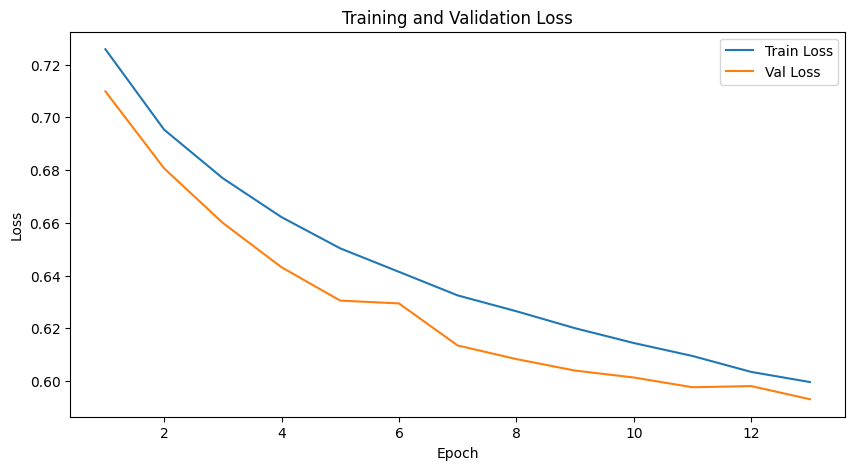

In [ ]:
# Train the model
best_epoch = train(ViT, Train_dataloader, Val_dataloader, optimizer, criterion, device, save_dir, model_name="ViT_1x1", epochs=25, patience=5)

In [ ]:
ViT = load_by_epoch(ViT, "ViT_1x1", save_dir, best_epoch, device)

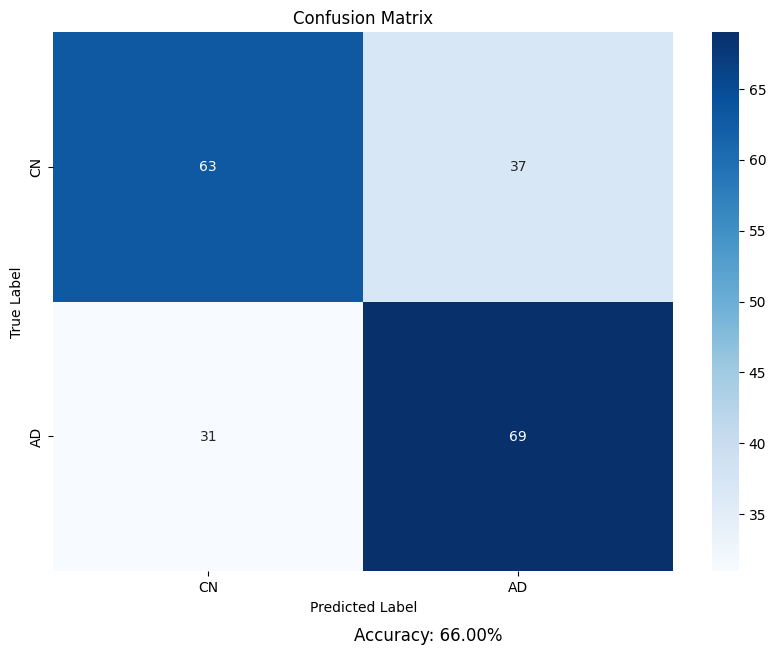

In [ ]:
accuracy = cm_and_acc(ViT, Test_dataloader, device)

In [ ]:
y_true, y_pred, y_scores = evaluate_model(ViT, Test_dataloader)

In [ ]:
auc = roc_auc_score(y_true, y_scores)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
specificity = calculate_specificity(y_true, y_pred)

print(f'AUC: {auc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')

AUC: 0.5379
Recall: 0.69
Precision: 0.6509433962264151
F1 Score: 0.6699029126213591
Specificity: 0.63
